In [3]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Generate Data

$p(x, y) = N(\mu_x = 0, \mu_y = 0, \sigma_x = 1, \sigma_y = 1, r = 0.5)$

$p(x_{obs}, y_{obs}|x, y) = N(\mu_x = x, \mu_y = y, \sigma_x = 1, \sigma_y = 1, r = 0)$

In [11]:
x, y = multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]]).rvs(1000).T

(-4.0, 4.0)

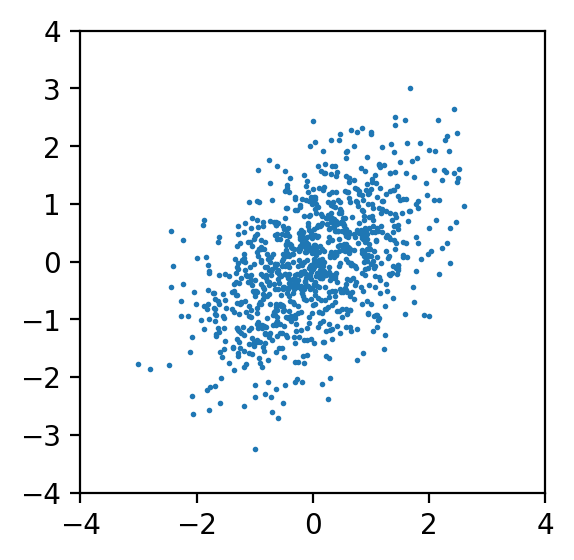

In [18]:
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(x, y, s=1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [23]:
# estimate the mean and covariance of the data
mean = np.mean([x, y], axis=1)
cov = np.cov([x, y])
mean, cov

(array([ 0.01965761, -0.00848411]),
 array([[0.96949341, 0.48835993],
        [0.48835993, 0.95922913]]))

In [35]:
# generate x_obs, y_obs
x_obs = np.zeros_like(x)
y_obs = np.zeros_like(y)
for i, (xi, yi) in enumerate(zip(x, y)):
    x_obs[i], y_obs[i] = multivariate_normal(mean=[xi, yi], cov=[[1, 0], [0, 1]]).rvs(1).T

(-5.0, 5.0)

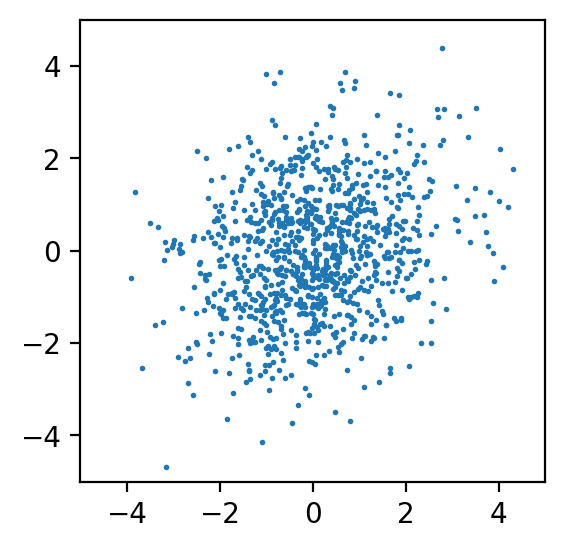

In [37]:
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(x_obs, y_obs, s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [38]:
mean = np.mean([x_obs, y_obs], axis=1)
cov = np.cov([x_obs, y_obs])
mean, cov

(array([ 0.02131784, -0.03750399]),
 array([[1.89483267, 0.45354803],
        [0.45354803, 1.90129859]]))

## Inference

$$
q(x, y|x_{obs}, y_{obs}) = \frac{p(x_{obs}, y_{obs}|x, y)q(x, y)}{q(x_{obs}, y_{obs})} = N(\mu', \Sigma')
$$

https://math.stackexchange.com/questions/157172/product-of-two-multivariate-gaussians-distributions

In [41]:
def get_posterior(x_obs, y_obs, mean_prior, cov_prior):
    # calculate the parameter of posterior distribution
    cov1 = np.array([[1, 0], [0, 1]])
    mean1 = np.array([x_obs, y_obs])
    cov2 = np.asarray(cov_prior)
    mean2 = np.asarray(mean_prior)
    S1S2_inv = np.linalg.inv(cov1 + cov2)
    _mean = cov2 @ S1S2_inv @ mean1 + cov1 @ S1S2_inv @ mean2
    _cov = cov1 @ S1S2_inv @ cov2
    return _mean, _cov

In [79]:
def one_step(x_obs, y_obs, mean, cov, N=100):
    mean_post_list = []
    cov_post_list = []

    for x_obs_i, y_obs_i in zip(x_obs, y_obs):
        _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean, cov)
        mean_post_list.append(_mean)
        cov_post_list.append(_cov)

    x_post_all = np.zeros((x.shape[0], N))
    y_post_all = np.zeros((y.shape[0], N))

    for i, (_mean, _cov) in enumerate(zip(mean_post_list, cov_post_list)):
        x_post_all[i], y_post_all[i] = multivariate_normal(mean=_mean,
                                                        cov=_cov).rvs(N).T

    x_post_all = x_post_all.flatten()
    y_post_all = y_post_all.flatten()

    mean_new = np.mean([x_post_all, y_post_all], axis=1)
    cov_new = np.cov([x_post_all, y_post_all])

    return mean_new, cov_new

In [91]:
mean_0 = [0, 0]
cov_0 = [[0.5, 0], [0, 0.5]]

_mean = mean_0
_cov = cov_0
for i in range(20):
    _mean, _cov = one_step(x_obs, y_obs, _mean, _cov, N=100)
    if i % 5 == 0:
        print('-----')
        print(i)
        print(_mean)
        print(_cov)

print('-----')
print('final')
print(_mean)
print(_cov)

-----
0
[ 0.00646047 -0.01334909]
[[0.5420625  0.04925301]
 [0.04925301 0.54383425]]
-----
5
[ 0.02145965 -0.03789218]
[[0.77957266 0.31304721]
 [0.31304721 0.78854694]]
-----
10
[ 0.02056791 -0.03961781]
[[0.87531812 0.42772253]
 [0.42772253 0.89143077]]
-----
15
[ 0.0223471  -0.03423564]
[[0.89131688 0.44315927]
 [0.44315927 0.90033026]]
-----
final
[ 0.0229889  -0.03600579]
[[0.89303393 0.45149715]
 [0.45149715 0.9037809 ]]
